In [1]:
import sys
import os
from itertools import combinations

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class MicrogliaTrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "MICROGLIA_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # file load UI
        self.layout_file_load = QHBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 2)
        # extra UI (bottom)
        self.layout_extra_ui = QHBoxLayout()
        self.layout_main.addLayout(self.layout_extra_ui, 1, 1, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)

        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # clear layouts
            clearLayout(self.layout_main_ui)
            clearLayout(self.layout_extra_ui)
        
        # set up main UI
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()
        self.initializeDataControlForXYCT()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success = self.data_manager.loadTiffStack(
                app_key=app_key, 
                path_tiff=self.widget_manager.dict_lineedit[f"path_tiff"].text()
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_extra_ui.addLayout(self.makeLayoutSectionBottomExtra())

    def setupControls(self):
        for app_key in self.app_keys:
            self.control_manager.table_controls[app_key] = TableControl(
                app_key=app_key,
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
            )
            self.control_manager.table_controls[app_key].setupWidgetDynamicTable(app_key)

            self.control_manager.view_controls[app_key] = ViewControl(
                app_key=app_key,
                q_view=self.widget_manager.dict_view[app_key], 
                q_scene=self.widget_manager.dict_scene[app_key], 
                data_manager=self.data_manager, 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
            )
            # self.control_manager.view_controls[app_key].setViewSize()
            # self.control_manager.view_controls[app_key].setShowRegImROI(False)
            # self.control_manager.view_controls[app_key].setShowRegStack(False)

        # set "sec" view's slider to "1"
        self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"].setValue(1)
        self.control_manager.view_controls[self.app_keys[1]].setPlaneT(1)
        self.control_manager.table_controls[self.app_keys[1]].setPlaneT(1)

    # for XYCT data, control
    def initializeDataControlForXYCT(self):
        for plane_t in range(self.data_manager.getSizeOfT(self.app_keys[0])):
            self.data_manager.dict_roi_coords_xyct[plane_t] = {}
            self.data_manager.dict_roi_coords_xyct_reg[plane_t] = {}
            self.data_manager.dict_roi_matching["id"][plane_t] = []
            for app_key in self.app_keys:
                self.control_manager.view_controls[app_key].roi_colors_xyct[plane_t] = {}

        list_plane_combi = list(combinations(range(self.data_manager.getSizeOfT(self.app_keys[0])), 2))
        for plane_pri, plane_sec in list_plane_combi:
            # Initialize the nested dictionaries if not already present
            if plane_pri not in self.data_manager.dict_roi_matching["match"]:
                self.data_manager.dict_roi_matching["match"][plane_pri] = {}
            if plane_sec not in self.data_manager.dict_roi_matching["match"][plane_pri]:
                self.data_manager.dict_roi_matching["match"][plane_pri][plane_sec] = {}


    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        # Label
        layout.addWidget(self.widget_manager.makeWidgetLabel(key="load_tiff", label="File Load", font_size=12, bold=True, italic=True, use_global_style=False))
        # LineEdit
        key = "path_tiff"
        layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label="tiff stack (XYCT) file path", key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left/Right Upper"
    # XYCT tiff stack view, slider
    def makeLayoutComponentImageView(self, app_key):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            app_key,
            slider_z=False,
            slider_t=True,
            key_label_t=f"{app_key}_plane_t",
            key_slider_t=f"{app_key}_plane_t",
            stack_size_t=self.data_manager.getSizeOfT(app_key),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout

    # Table, ROI IO
    def makeLayoutComponentTable_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addWidget(self.widget_manager.makeWidgetTable(app_key))
        layout.addLayout(makeLayoutROIManagerForTable(
            self.widget_manager,
            key_button_roi_add=f"{app_key}_roi_add",
            key_button_roi_remove=f"{app_key}_roi_remove",
            key_button_roi_edit=f"{app_key}_roi_edit",
        ))
        layout.addLayout(makeLayoutROIEditConfig(
            self.widget_manager,
            key_label_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_label_pen_radius=f"{app_key}_pen_radius",
            key_slider_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_spinbox_pen_radius=f"{app_key}_pen_radius",
        ))
        return layout
    
    # View, slider
    def makeLayoutComponent_View_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    "Bottom Extra"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutMicrogliaXYCTStackRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",
            f"opacity_roi_pair",
            f"elastix_method",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",          
            f"elastix_config", 
            f"elastix_run_t",   
            f"export_reg_tiff",
            f"show_roi_match",
            f"show_roi_pair",
            f"show_reg_stack",
            f"show_reg_im_roi",
            f"opacity_roi_pair",
        )
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_method",
            "ot_run",
            "ot_clear",
        ))
        layout.addWidget(self.widget_manager.makeWidgetButton("ot_run_all_tplanes", "Run Optimal Transport for all t-planes"))
        layout.addLayout(makeLayoutROIMatchingTest(
            self.widget_manager,
            "roi_matching_test",
        ))
        layout.addLayout(makeLayoutROITrackingIO(
            self.widget_manager,
            "roi_matching_save",
            "roi_matching_load",
        ))
        return layout
    
    # ROI Manager
    def makeLayoutComponentCellposeROIManager(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutCellpose(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],
            "cellpose",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_run",
            "cellpose_save",
            "cellpose_load",
        ))
        layout.addLayout(makeLayoutROIManager(
            self.widget_manager,
            "roi_manager",
            "roi_save",
            "roi_load",
        ))
        return layout

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    # View size : Table size = 2 : 1
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[0]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[0]), 1)
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[1]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[1]), 1)
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    # 下段, 追加
    def makeLayoutSectionBottomExtra(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        layout.addLayout(self.makeLayoutComponentCellposeROIManager())
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):        
        bindFuncLoadFileWidget(
            q_widget=self, 
            q_button=self.widget_manager.dict_button["path_tiff"], 
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"], 
            filetype=Extension.TIFF
        )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        for app_key in self.app_keys:
            # Slider Opacity valueChanged
            bindFuncOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_all"],
                view_control=self.control_manager.view_controls[app_key],
            )
            bindFuncHighlightOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_selected"],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Contrast valueChanged, Checkbox show channel stateChanged
            for channel in self.config_manager.gui_defaults["CHANNELS"]:
                bindFuncBackgroundContrastSlider(
                    q_slider_min=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_min"],
                    q_slider_max=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_max"],
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel
                )
                bindFuncBackgroundVisibilityCheckbox(
                    q_checkbox=self.widget_manager.dict_checkbox[f"{app_key}_{channel}_show"], 
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel,
                )
            # ROI Manager for Table
            bindFuncButtonsROIManagerForTable(
                q_button_add=self.widget_manager.dict_button[f"{app_key}_roi_add"],
                q_button_remove=self.widget_manager.dict_button[f"{app_key}_roi_remove"],
                q_button_edit=self.widget_manager.dict_button[f"{app_key}_roi_edit"],
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                control_manager=self.control_manager,
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
                app_key_pri=self.app_keys[0],
                app_key_sec=self.app_keys[1]
            )
            # ROI Edit Config
            bindFuncSliderSpinBoxROIEditConfig(
                q_slider_opacity=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_edit"],
                q_spinbox_radius=self.widget_manager.dict_spinbox[f"{app_key}_pen_radius"],
                view_control=self.control_manager.view_controls[app_key]
            )
            # View Event
            bindFuncViewEvents(
                q_view=self.widget_manager.dict_view[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )

        # T slider
        bindFuncPlaneTSliderWithXYCTTracking(
            q_slider_pri=self.widget_manager.dict_slider[f"{self.app_keys[0]}_plane_t"],
            q_slider_sec=self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
        )
        # ROI Table onSelectionChanged
        bindFuncTableSelectionChangedWithTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            q_table_sec=self.widget_manager.dict_table[self.app_keys[1]],
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
            view_control_pri=self.control_manager.view_controls[self.app_keys[0]],
            view_control_sec=self.control_manager.view_controls[self.app_keys[1]],
            canvas_control_pri=None,
            canvas_control_sec=None,
        )
        # ROI Table onCellChanged
        bindFuncTableCellChangedWithMicrogliaTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            control_manager=self.control_manager,
            data_manager=self.data_manager,
        )
        # Cellpose ROI mask IO
        bindFuncROIMaskNpyIO(
            q_button_save=self.widget_manager.dict_button["cellpose_load"], # temporary fix
            q_button_load=self.widget_manager.dict_button["cellpose_load"],
            q_window=self,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key=self.app_keys[0]
        )
        # ImageJ ROI Manager zip IO
        bindFuncROIManagerZipIO(
            q_button_save=self.widget_manager.dict_button["roi_save"],
            q_button_load=self.widget_manager.dict_button["roi_load"],
            q_window=self,
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
        )
        # Show matched ROI
        bindFuncCheckboxShowMatchedROI(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_match'],
            view_controls=self.control_manager.view_controls
        )
        # Show ROI pair
        bindFuncCheckboxShowROIPair(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_pair'],
            view_controls=self.control_manager.view_controls
        )
        # Slider ROI pair Opacity valueChanged
        bindFuncROIPairOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"opacity_roi_pair"],
            view_control=self.control_manager.view_controls[self.app_keys[0]],
        )
        # Show registered background image
        bindFuncCheckboxShowRegisteredStack(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_stack'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered ROI image
        bindFuncCheckboxShowRegisteredROIImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_roi'],
            view_controls=self.control_manager.view_controls
        )
        # run Elastix registration t-axis
        bindFuncButtonRunElastixForMicrogliaXYCTStackRegistration(
            self,
            q_button=self.widget_manager.dict_button[f"elastix_run_t"],
            data_manager=self.data_manager,
            config_manager=self.config_manager,
            app_keys=self.app_keys,
            combobox_elastix_method=self.widget_manager.dict_combobox[f"elastix_method"],
            combobox_channel_ref=self.widget_manager.dict_combobox[f"elastix_ref_c"],
            combobox_idx_ref=self.widget_manager.dict_combobox[f"elastix_ref_plane_t"],
        )
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )
        # Microglia Tracking IO
        bindFuncMicrogliaTrackingIO(
            self.widget_manager.dict_button["roi_matching_save"],
            self.widget_manager.dict_button["roi_matching_load"],
            self,
            self.widget_manager.dict_lineedit["path_tiff"],
            self.config_manager,
            self.data_manager,
            self.control_manager,
        )
        # ROI Matching Run
        bindFuncButtonRunROIMatchingForXYCT(
            self,
            q_button_run=self.widget_manager.dict_button['ot_run'],
            q_button_run_all_tplanes=self.widget_manager.dict_button['ot_run_all_tplanes'],
            widget_manager=self.widget_manager,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # Clear ROI Matching result
        bindFuncButtonClearROIMatching(
            q_button=self.widget_manager.dict_button['ot_clear'],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # run Cellpose
        bindFuncButtonRunCellposeForXYCT(
            self.data_manager,
            self.control_manager,
            self.config_manager,
            self.widget_manager.dict_button["cellpose_run"],
            self.widget_manager.dict_combobox["cellpose_t_plane"],
            self.widget_manager.dict_combobox["cellpose_channel"],
            self.widget_manager.dict_combobox["cellpose_model"],
            self.widget_manager.dict_combobox["cellpose_restore"],
            self.widget_manager.dict_spinbox["cellpose_diameter"],
        )

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = MicrogliaTrackingGUI()
    gui.show()
    sys.exit(app.exec_())

ROI load error:  M031_S05
WRONG NAMING AND WRONG T_PLANE
ROI load error:  M050_S03
WRONG NAMING AND WRONG T_PLANE
ROI selected: 10
ROI selected: 52
ROI selected: 51
ROI selected: 44
ROI selected: 34
ROI selected: 40
ROI selected: 63


SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


In [15]:
from roifile import roiread
from optic.preprocessing.preprocessing_imagej import convertROIContourToFilled

path_rois = "D:/optic_figure/data/fig5_Saito/Saline/MDA33/MDA33_cropped_con_RoiSet.zip"

rois = roiread(path_rois)

In [16]:
# anchor dict for dict_roi_matching["match"]
# ex) {"m001": {0: 1, 1: 2, 2: 4, 3: 2}, "m002": {0: 3, 1: 4, 2: 5, 3: 6}}
dict_roi_matching_anchor: Dict[str, Dict[int, int]] = {}

# some roi.name are duplicated, so check and skip duplicated roi
list_roi_name = [roi.name for roi in rois]
list_duplicate_roi_name = [name for name in list_roi_name if list_roi_name.count(name) > 1]

In [37]:
dict_error = {}
img_width = 1024
img_height = 1024

# anchor dict for dict_roi_matching["match"]
# ex) {"m001": {0: 1, 1: 2, 2: 4, 3: 2}, "m002": {0: 3, 1: 4, 2: 5, 3: 6}}
dict_roi_matching_anchor: Dict[str, Dict[int, int]] = {}

# some roi.name are duplicated, so check and skip duplicated roi
list_roi_name = [roi.name for roi in rois]
list_duplicate_roi_name = [name for name in list_roi_name if list_roi_name.count(name) > 1]

# get roi_matching["id"] and roi_coords_xyct
for i, roi in enumerate(rois):
    # skip duplicated roi
    if roi.name in list_duplicate_roi_name:
        print("ROI load error: ", roi.name)
        print("DUPLICATED")
        dict_error[roi.name] = "DUPLICATED"
        continue
    roi_name = roi.name # MXXX_SXX
    roi_name = roi_name.replace(" ", "") # remove space
    roi_name = roi_name.upper() # mXXX_sXX -> MXXX_SXX
    roi_name = roi_name.replace("-", "_") # MXXX-SXX -> MXXX_SXX

    # only RECT, TRACED, FREEHAND !!!
    if roi.roitype == 1 or roi.roitype == 7 or roi.roitype == 8:
        try:
            # RECT
            if roi.roitype == 1: 
                roi_xy_coords = roi.multi_coordinates
                list_roi_coords_segment = []

                seg_start = 0
                seg_end = len(roi_xy_coords)
                for i in range(len(roi_xy_coords)):
                    try:
                        # pick up 2 elements
                        pri, sec = roi_xy_coords[i], roi_xy_coords[i+1]
                        if pri == 4 and sec == 0: # border of segments (4, 0)
                            seg_end = i
                            list_roi_coords_segment.append(roi_xy_coords[seg_start:seg_end+1])
                            seg_start = i+1
                    except IndexError: # end of list
                        seg_end = i
                        list_roi_coords_segment.append(roi_xy_coords[seg_start:seg_end+1])
                xpix_contour = np.concatenate([roi_coords_segment[1::3] for roi_coords_segment in list_roi_coords_segment])
                ypix_contour = np.concatenate([roi_coords_segment[2::3] for roi_coords_segment in list_roi_coords_segment])
            # TRACED, FREEHAND
            elif roi.roitype == 7 or roi.roitype == 8: 
                roi_x_start = roi.left
                roi_y_start = roi.top
                roi_xy_coords = roi.integer_coordinates

                xpix_contour = roi_xy_coords[:, 0] + roi_x_start
                ypix_contour = roi_xy_coords[:, 1] + roi_y_start

            xpix_ypix_contour = np.column_stack((xpix_contour, ypix_contour)).astype("uint16")
            # convert contour to filled roi
            xpix_ypix = convertROIContourToFilled(xpix_ypix_contour, img_width, img_height)
            xpix, ypix = xpix_ypix[:, 0], xpix_ypix[:, 1]
            med = np.array([np.median(xpix).astype("uint16"), np.median(ypix).astype("uint16")])
        except Exception as e:
            print("ROI load error: ", roi.name)
            raise e

ROI load error:  M001_S01


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2433: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'cv::fillPoly'


In [39]:
from shapely.geometry import Polygon
import rasterio.features
import numpy as np

def fill_any_polygon(points, img_width, img_height):
    # Shapelyポリゴン作成
    polygon = Polygon(points.copy())
    
    # ポリゴンをラスタライズ
    mask = rasterio.features.rasterize(
        [(polygon, 1)],
        out_shape=(img_height, img_width)
    )
    
    # 結果を(x,y)座標のリストとして返す
    y_indices, x_indices = np.where(mask > 0)
    return np.column_stack((x_indices, y_indices))

xpix_ypix_contour_filled = fill_any_polygon(xpix_ypix_contour, img_width, img_height)

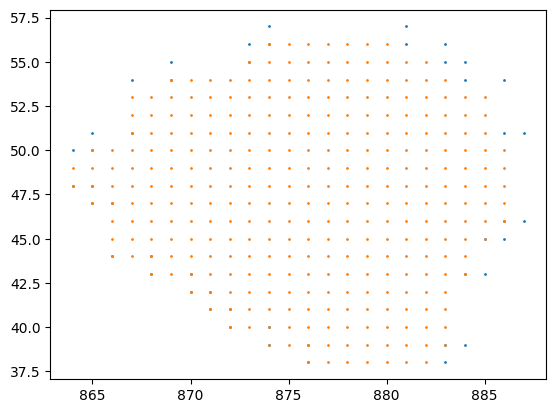

In [40]:
import matplotlib.pyplot as plt
plt.scatter(xpix_ypix_contour[:, 0], xpix_ypix_contour[:, 1], s=1)
plt.scatter(xpix_ypix_contour_filled[:, 0], xpix_ypix_contour_filled[:, 1], s=1)

In [17]:
roi_rect = rois[77]

"""
ROI_TYPE.RECT coordinates format
["operation", "x", "y", "operation", "x", "y", ...]
- operation: 0 (start), 1 (line), 4 (end)
extract segment (0, 1, 1, ..., 4) and extract xy coordinates
"""
roi_rect

ImagejRoi(
    roitype=ROI_TYPE.RECT,
    name='M011_S01',
    version=228,
    top=351,
    left=639,
    bottom=377,
    right=676,
    shape_roi_size=297,
    stroke_color=b'\xff\x1f\x96\x98',
    z_position=61,
    t_position=1,
    group=12,
    multi_coordinates=numpy.array([  0., 652., 375.,   1., 652., 376.,   1., 653., 376.,   1., 653.,
        375.,   4.,   0., 654., 375.,   1., 654., 376.,   1., 655., 376.,
       1., 655., 375.,   4.,   0., 651., 351.,   1., 651., 352.,   1.,
        649., 352.,   1., 649., 353.,   1., 645., 353.,   1., 645., 354.,
       1., 644., 354.,   1., 644., 355.,   1., 642., 355.,   1., 642.,
        356.,   1., 641., 356.,   1., 641., 357.,   1., 640., 357.,   1.,
        640., 358.,   1., 640., 360.,   1., 639., 360.,   1., 639., 365.,
       1., 639., 368.,   1., 640., 368.,   1., 640., 369.,   1., 642.,
        369.,   1., 642., 370.,   1., 644., 370.,   1., 644., 371.,   1.,
        646., 371.,   1., 646., 372.,   1., 647., 372.,   1., 647., 3

In [18]:
roi_xy_coords = roi_rect.multi_coordinates

list_roi_coords_segment = []

seg_start = 0
seg_end = len(roi_xy_coords)
for i in range(len(roi_xy_coords)):
    try:
        # pick up 2 elements
        pri, sec = roi_xy_coords[i], roi_xy_coords[i+1]
        if pri == 4 and sec == 0: # border of segments (4, 0)
            seg_end = i
            list_roi_coords_segment.append(roi_xy_coords[seg_start:seg_end+1])
            seg_start = i+1
    except IndexError: # end of list
        seg_end = i
        list_roi_coords_segment.append(roi_xy_coords[seg_start:seg_end+1])

xpix_contour = np.concatenate([roi_coords_segment[1::3] for roi_coords_segment in list_roi_coords_segment])
ypix_contour = np.concatenate([roi_coords_segment[2::3] for roi_coords_segment in list_roi_coords_segment])
xpix_ypix_contour = np.column_stack((xpix_contour, ypix_contour))

In [19]:
list_roi_coords_segment[0][1::3]
list_roi_coords_segment[0][2::3]

array([375., 376., 376., 375.], dtype=float32)

In [24]:
xpix_ypix_contour

array([[652., 375.],
       [652., 376.],
       [653., 376.],
       [653., 375.],
       [654., 375.],
       [654., 376.],
       [655., 376.],
       [655., 375.],
       [651., 351.],
       [651., 352.],
       [649., 352.],
       [649., 353.],
       [645., 353.],
       [645., 354.],
       [644., 354.],
       [644., 355.],
       [642., 355.],
       [642., 356.],
       [641., 356.],
       [641., 357.],
       [640., 357.],
       [640., 358.],
       [640., 360.],
       [639., 360.],
       [639., 365.],
       [639., 368.],
       [640., 368.],
       [640., 369.],
       [642., 369.],
       [642., 370.],
       [644., 370.],
       [644., 371.],
       [646., 371.],
       [646., 372.],
       [647., 372.],
       [647., 373.],
       [650., 373.],
       [650., 374.],
       [651., 374.],
       [651., 375.],
       [652., 375.],
       [652., 374.],
       [655., 374.],
       [655., 375.],
       [659., 375.],
       [659., 376.],
       [661., 376.],
       [661.,

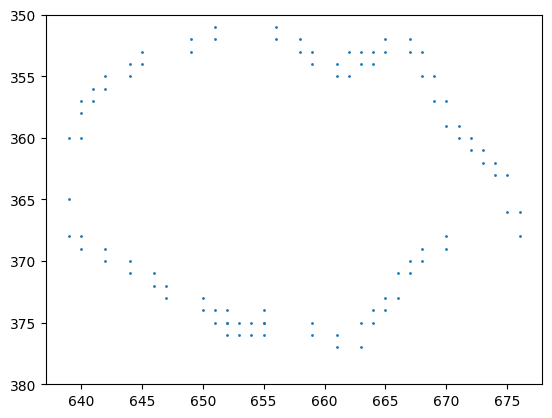

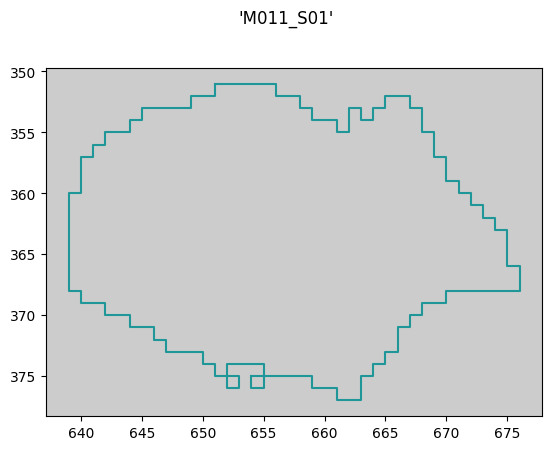

In [23]:
import matplotlib.pyplot as plt
plt.scatter(xpix_ypix_contour[:, 0], xpix_ypix_contour[:, 1], s=1)
plt.ylim(380, 350)
roi_rect.plot()

In [84]:
from scipy.io import loadmat

mat = loadmat("D:/optic_figure/data/fig5/unreg_typical/Microgliatracking_MDA68_AVG_concatenate_zcrop_11_1-9.mat", simplify_cells=True)

id_ = mat["ROI"]["save_250326_135614"]["ROITracking"]["id"]
match_ = mat["ROI"]["save_250326_135614"]["ROITracking"]["match"]

In [94]:
match_[0].ndim

1

In [58]:
match_[0].shape

(0,)

In [92]:
match_.ndim

1